<a href="https://colab.research.google.com/github/markustoivonen/AIHealthTech2020/blob/master/exercises/ex4_4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from tensorflow.math import confusion_matrix


In [63]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0


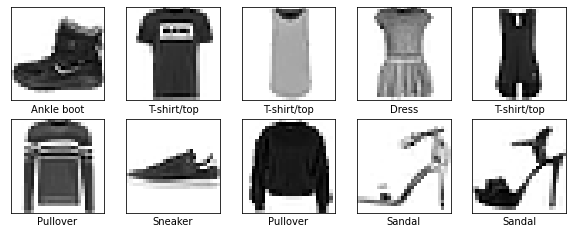

In [64]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

In [65]:

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")


In [66]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [67]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10)

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
model = MyModel()


In [68]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()


In [69]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')


In [70]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)


In [71]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [72]:
predictions = tf.argmax(model(x_test),1)
labels = y_test
confusion_matrix(labels, predictions)

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[  0,   0,   1,  35, 694, 188,  40,  36,   6,   0],
       [ 23,   5,   0, 622, 219,   5, 108,  18,   0,   0],
       [  0,   0,   0,  14, 432,  13, 346, 195,   0,   0],
       [  0,   0,   5, 110, 763,  59,  39,  22,   1,   1],
       [  0,   0,   0,  48, 445,  12, 415,  80,   0,   0],
       [  0,   0,   4,  87, 546,  10, 284,  19,   7,  43],
       [  0,   0,   1,  38, 568,  38, 294,  58,   3,   0],
       [  0,   0,   0, 359, 509,   2, 101,   0,   1,  28],
       [  0,   0,  16,  11, 179,  14, 773,   6,   1,   0],
       [  0,   0,   0,   5, 965,   0,  18,  11,   0,   1]], dtype=int32)>

In [73]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print(template.format(epoch + 1,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        test_loss.result(),
                        test_accuracy.result() * 100))


Epoch 1, Loss: 0.3715689182281494, Accuracy: 86.7750015258789, Test Loss: 0.2959851622581482, Test Accuracy: 89.37000274658203
Epoch 2, Loss: 0.24690109491348267, Accuracy: 90.81999969482422, Test Loss: 0.2739301025867462, Test Accuracy: 89.84000396728516
Epoch 3, Loss: 0.191156804561615, Accuracy: 92.86000061035156, Test Loss: 0.2670326828956604, Test Accuracy: 90.52000427246094
Epoch 4, Loss: 0.14633809030056, Accuracy: 94.58499908447266, Test Loss: 0.2839689552783966, Test Accuracy: 90.45999908447266
Epoch 5, Loss: 0.11207562685012817, Accuracy: 95.8183364868164, Test Loss: 0.3186590373516083, Test Accuracy: 90.44000244140625


In [77]:
predictions = tf.argmax(model(x_test),1)
labels = y_test
confusion_matrix(labels, predictions)

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[824,   2,  14,  19,   9,   4, 120,   0,   8,   0],
       [  0, 978,   1,  10,   5,   1,   3,   0,   2,   0],
       [ 14,   1, 813,  10,  87,   0,  75,   0,   0,   0],
       [  9,   6,   9, 928,  20,   1,  25,   0,   2,   0],
       [  0,   1,  37,  32, 885,   0,  45,   0,   0,   0],
       [  0,   0,   0,   0,   0, 982,   0,  12,   0,   6],
       [ 75,   0,  38,  30,  90,   0, 761,   0,   6,   0],
       [  0,   0,   0,   0,   0,  15,   0, 981,   1,   3],
       [  1,   3,   2,   5,   1,   2,   6,   3, 977,   0],
       [  0,   0,   0,   0,   0,   9,   2,  74,   0, 915]], dtype=int32)>